In [ ]:
!pip install tenacity==8.5.0
!pip install -U langgraph langchain-ollama

Imports

In [2]:
import sys
import os

# Add the parent directory of the current file's location to the sys.path
sys.path.append(os.path.abspath("../src"))

from dotenv import load_dotenv
import neo4j
from ast import literal_eval
from langchain_ollama import ChatOllama
from langchain_core.tools import tool
from langgraph.prebuilt import create_react_agent
from queries import get_abstracts, get_abstract_pmids, get_functional_term_proteins, cosine_similiarity
from IPython.display import Image, display
from summarization.article_graph import generate_embedding
from queries import get_functional_term_proteins

Necessary function

In [3]:
def get_driver():
    load_dotenv()

    # set config
    NEO4J_HOST = os.getenv("NEO4J_HOST")
    NEO4J_PORT = os.getenv("NEO4J_PORT")
    NEO4J_PASSWORD = os.getenv("NEO4J_PASSWORD")
    NEO4J_USERNAME = os.getenv("NEO4J_USERNAME")
    # connect
    uri = f"bolt://{NEO4J_HOST}:{NEO4J_PORT}"
    driver = neo4j.GraphDatabase.driver(uri, auth=(NEO4J_USERNAME, NEO4J_PASSWORD))
    return driver

def abstracts_for_agent(query):
    query = literal_eval(query)
    driver = get_driver()
    test = get_abstracts(driver=driver, species="Mus_Musculus", query=query)
    abstracts =[{i["PMID"]: i["abstract"]} for i in test]
    driver.close()
    return abstracts

def pmids_for_agent(query):
    query = literal_eval(query)
    driver = get_driver()
    test = get_abstract_pmids(driver=driver, species="Mus_Musculus", query=query)
    pmids =[i["PMID"] for i in test]
    driver.close()
    return pmids
def split_list(input_list):
    # Find the midpoint
    midpoint = len(input_list) // 2
    
    # Split the list
    list1 = input_list[:midpoint]
    list2 = input_list[midpoint:]
    
    return [list1, list2]

Tools

In [28]:
@tool
def get_abstracts_for_proteins(protein, query) -> str:
    "Queries neo4j to retrieve abstracts relevant to proteins, use for questions about proteins. first argument should be a python list of proteins, second argument should be the question"
    driver = get_driver()
    embedded_query = generate_embedding(query)
    pmids = get_abstract_pmids(driver=driver, species="Mus_Musculus", query=protein)
    pmids =[i["PMID"] for i in pmids]
    abstracts = cosine_similiarity(driver=driver, pmids=pmids, embedding=embedded_query)
    if len(abstracts) == 0:
        return "No abstracts found, does the input have the correct format? first argument should be a python list of proteins, second argument should be string of the question"
    return "abstracts related to the query: "+ "\n".join(abstracts)


@tool
def get_proteins_from_functional_terms(funct_term: list) -> list:
    "Queries neo4j to retrieve proteins associated to a functional term, use this only if a the user asks about which proteins are involved in functional pathway not functions. Argument should be a list of functional terms of format term~source"
    driver = get_driver()
    proteins = get_functional_term_proteins(driver, funct_term)
    driver.close()
    if len(proteins) == 0:
        return ["No proteins found, format of input is funct_term~source, maybe use another tool?"]
    return f"the associated proteins are: {proteins}"


tools = [get_proteins_from_functional_terms, get_abstracts_for_proteins]

Model definition

In [29]:
model = ChatOllama(model="llama3.1")
graph = create_react_agent(model, tools=tools)

Agent graph generation

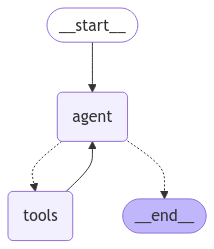

In [30]:
display(Image(graph.get_graph().draw_mermaid_png()))

Stream output

In [31]:
def print_stream(stream):
    for s in stream:
        message = s["messages"][-1]
        if isinstance(message, tuple):
            print(message)
        else:
            message.pretty_print()

Agent calling

In [34]:
#inputs = {"messages": [("user", "What are proteins associated in PWY-5910~BIOCYC and PWY0-1305~BIOCYC")]}
inputs = {"messages": [("user", "whats the role of cd40?")]}

print_stream(graph.stream(inputs, stream_mode="values"))

================================ Human Message =================================

whats the role of cd40?
================================== Ai Message ==================================
Tool Calls:
  get_abstracts_for_proteins (9050810e-5230-4954-b23e-628bedded98e)
 Call ID: 9050810e-5230-4954-b23e-628bedded98e
  Args:
    protein: ['cd40']
    query: role
================================= Tool Message =================================
Name: get_abstracts_for_proteins

No abstracts found, does the input have the correct format? first argument should be a python list of proteins, second argument should be string of the question
================================== Ai Message ==================================
Tool Calls:
  get_abstracts_for_proteins (9c6386ae-9349-4749-8b23-c550d4dae83c)
 Call ID: 9c6386ae-9349-4749-8b23-c550d4dae83c
  Args:
    protein: ['CD40']
    query: role
================================= Tool Message =================================
Name: get_abstracts_for_prote